<a href="https://colab.research.google.com/github/Formula-Electric-Berkeley/FEBSim/blob/main/SkidPadTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total time to complete the skidpad: 5.31 seconds
   Time (s)  X Position (m)  Y Position (m)  Heading Angle (rad)  \
0   0.00000        0.000000       -7.625000             0.000000   
1   0.05005        0.006369       -7.624997             0.000004   
2   0.10010        0.021749       -7.624988             0.000015   
3   0.15015        0.047383       -7.624973             0.000034   
4   0.20020        0.083267       -7.624951             0.000061   

   Lateral Velocity (m/s)  Yaw Rate (rad/s)  Speed (m/s)  Motor Speed (rpm)  \
0                0.000000          0.000000     0.000000                0.0   
1                0.000119          0.000152     0.204872                0.0   
2                0.000236          0.000304     0.409733                0.0   
3                0.000346          0.000456     0.614570                0.0   
4                0.000447          0.000608     0.819372                0.0   

   Distance Traveled (m)  
0               0.000000  
1            

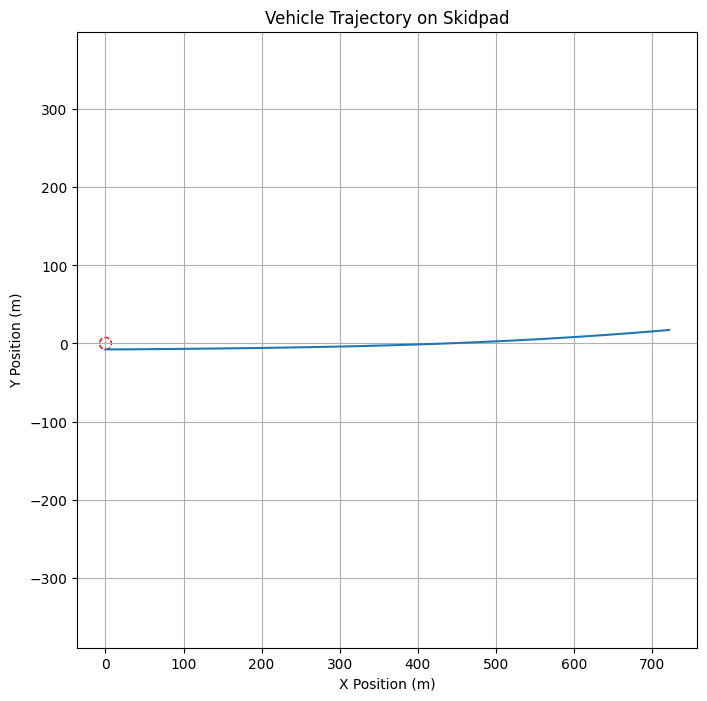

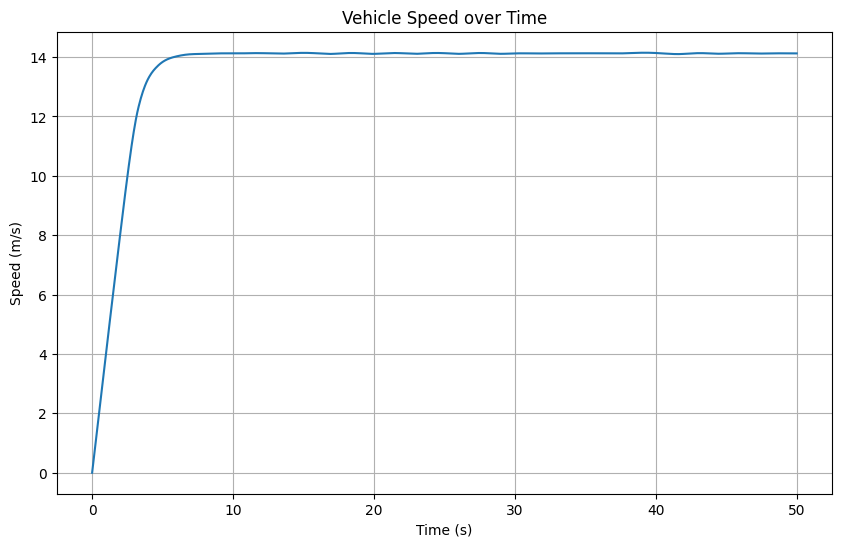

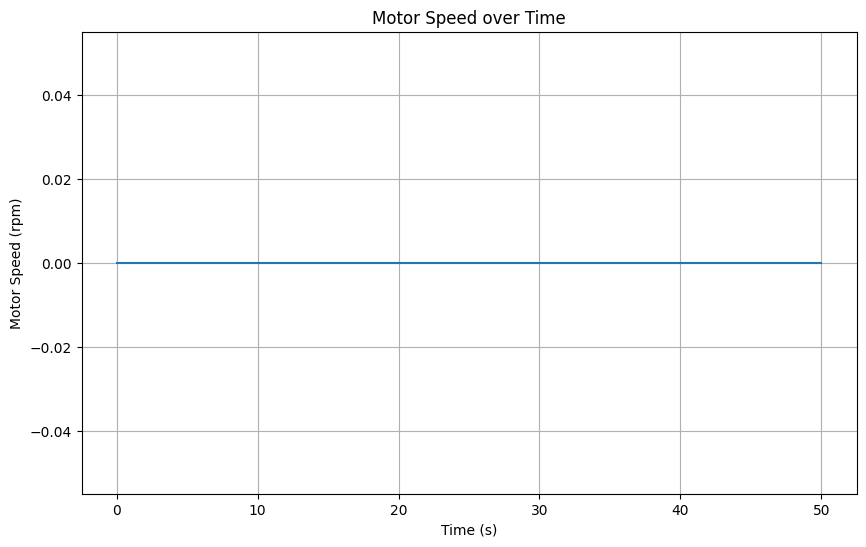

In [19]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def pacejka_model(alpha, params):
    """
    Calculates the lateral force using the Pacejka Magic Formula.
    """
    B = params['B']
    C = params['C']
    D = params['D']
    E = params['E']
    Sv = params['Sv']
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha)))) + Sv

def select_pacejka_params_for_load(FZ, pacejka_params_for_bins):
    """
    Selects the appropriate Pacejka parameters based on vertical load (FZ).
    """
    bins = sorted(pacejka_params_for_bins.keys())
    for bin_range in bins:
        lower, upper = bin_range
        if lower < FZ <= upper:
            return pacejka_params_for_bins[bin_range]
    # If FZ does not fall into any bin, use the closest available parameters
    FZ_abs = abs(FZ)
    min_diff = float('inf')
    closest_params = None
    for bin_range in bins:
        bin_lower, bin_upper = bin_range
        bin_center = (bin_lower + bin_upper) / 2
        diff = abs(FZ_abs - abs(bin_center))
        if diff < min_diff:
            min_diff = diff
            closest_params = pacejka_params_for_bins[bin_range]
    return closest_params

def calculate_load_transfer(lateral_acc, h_cg, track_width, axle_mass):
    """
    Calculates the load transfer for a given axle based on lateral acceleration.
    """
    # Calculate the load transfer (in Newtons) due to lateral acceleration
    load_transfer = -(axle_mass * lateral_acc * h_cg) / track_width
    return load_transfer

def compute_steering_angle(t, vehicle_params, path_params):
    """
    Computes the steering angle required to follow the skidpad path at time t.
    """
    wheelbase = vehicle_params['wheelbase']
    radius = path_params['radius']
    # Compute curvature (constant for skidpad)
    curvature = 1 / radius
    # Compute steering angle delta
    delta = np.arctan(wheelbase * curvature)
    return delta

def create_motor_torque_function(motor_speed_data, torque_data):
    """
    Creates an interpolation function for motor torque.
    """
    torque_function = interp1d(motor_speed_data, torque_data, kind='linear', fill_value="extrapolate")
    return torque_function

def bicycle_model_dynamics(t, state, vehicle_params, path_params, torque_function):
    # Unpack vehicle parameters
    mass = vehicle_params['mass']
    h_cg = vehicle_params['h_cg']
    track_width = vehicle_params['track_width']
    aero_params = vehicle_params['aero_params']
    L_f = vehicle_params['L_f']
    L_r = vehicle_params['L_r']
    I_z = vehicle_params['I_z']
    wheelbase = vehicle_params['wheelbase']
    tire_radius = vehicle_params['tire_radius']
    gear_ratio = vehicle_params['gear_ratio']
    final_drive_ratio = vehicle_params['final_drive_ratio']
    pacejka_params_for_bins = vehicle_params['pacejka_params_for_bins']
    drivetrain_efficiency = vehicle_params['drivetrain_efficiency']

    # State contains [x, y, psi, vy, yaw_rate, v, motor_speed]
    g = 9.81
    rho = 1.225  # kg/m^3
    x, y, psi, vy, yaw_rate, v, motor_speed = state

    # Ensure the vehicle speed is not zero to avoid division by zero
    if v <= 0.1:
        v = 0.1  # Minimum speed to prevent division by zero

    # Aerodynamic parameters
    C_L, C_D, A = aero_params

    # Aerodynamic downforce (proportional to square of speed)
    downforce = 0.5 * rho * v**2 * C_L * A

    # Aerodynamic drag
    drag_force = 0.5 * rho * v**2 * C_D * A

    # Rolling resistance
    rolling_resistance_coefficient = 0.015  # Typical value
    rolling_resistance = rolling_resistance_coefficient * mass * g

    # Mass split equally for simplicity (front and rear axle)
    mass_front = mass * 0.5
    mass_rear = mass * 0.5

    # Distribute aerodynamic downforce (assuming aero_balance of 0.5)
    aero_balance = 0.5  # Adjust this based on front/rear downforce distribution
    downforce_front = downforce * aero_balance
    downforce_rear = downforce * (1 - aero_balance)

    # Total axle weights including downforce (negative for downward force)
    total_weight_front = -(mass_front * g + downforce_front)
    total_weight_rear = -(mass_rear * g + downforce_rear)

    # Lateral acceleration (approximated)
    lateral_acc = (vy + L_f * yaw_rate) / v  # Lateral acceleration in m/s^2

    # Load transfer due to lateral acceleration
    load_transfer_front = calculate_load_transfer(lateral_acc, h_cg, track_width, mass_front)
    load_transfer_rear = calculate_load_transfer(lateral_acc, h_cg, track_width, mass_rear)

    # Vertical loads on the tires
    FZ_front = total_weight_front / 2 + load_transfer_front
    FZ_rear = total_weight_rear / 2 + load_transfer_rear

    # Select the appropriate Pacejka parameters based on vertical load
    pacejka_params_front = select_pacejka_params_for_load(FZ_front, pacejka_params_for_bins)
    pacejka_params_rear = select_pacejka_params_for_load(FZ_rear, pacejka_params_for_bins)

    # Compute steering angle
    delta = compute_steering_angle(t, vehicle_params, path_params)

    # Compute slip angles
    alpha_f = delta - np.arctan((vy + L_f * yaw_rate) / v)
    alpha_r = -np.arctan((vy - L_r * yaw_rate) / v)

    # Calculate lateral forces using the Pacejka model
    FY_front = pacejka_model(alpha_f, pacejka_params_front)
    FY_rear = pacejka_model(alpha_r, pacejka_params_rear)

    # Longitudinal forces
    # For EV, motor speed is directly related to wheel speed
    wheel_speed = v / tire_radius  # rad/s

    # Motor speed (assuming direct drive or fixed gear ratio)
    motor_speed = wheel_speed * gear_ratio * final_drive_ratio * (60 / (2 * np.pi))  # rpm

    # Get motor torque
    motor_torque = torque_function(motor_speed)

    # Calculate tractive force at wheels
    tractive_force = (motor_torque * gear_ratio * final_drive_ratio * drivetrain_efficiency) / tire_radius

    # Total longitudinal force
    F_long = tractive_force - drag_force - rolling_resistance

    # **Improved Braking Logic**
    # Calculate maximum allowable speed based on lateral acceleration limit
    max_lateral_acc = vehicle_params['max_lateral_acc']  # Maximum allowable lateral acceleration (m/s^2)
    max_speed = np.sqrt(max_lateral_acc * path_params['radius'])

    # Determine if braking is needed
    speed_error = v - max_speed
    if speed_error > 0:
        # Proportional controller to calculate required deceleration
        kp = 1.0  # Proportional gain (adjust as needed)
        required_deceleration = kp * speed_error
        # Limit deceleration to maximum braking deceleration (1g)
        deceleration = min(required_deceleration, g * vehicle_params['max_braking_g'])
        # Calculate braking force
        F_brake = mass * deceleration
        # Update total longitudinal force with braking
        F_long -= F_brake
    else:
        F_brake = 0  # No braking needed

    # Equations of motion
    x_dot = v * np.cos(psi) - vy * np.sin(psi)
    y_dot = v * np.sin(psi) + vy * np.cos(psi)
    psi_dot = yaw_rate
    vy_dot = (FY_front * np.cos(delta) + FY_rear) / mass - v * yaw_rate
    yaw_rate_dot = (L_f * FY_front * np.cos(delta) - L_r * FY_rear) / I_z
    v_dot = F_long / mass

    # Update motor speed derivative (assuming instantaneous response)
    motor_speed_dot = 0  # Simplification for now

    return [x_dot, y_dot, psi_dot, vy_dot, yaw_rate_dot, v_dot, motor_speed_dot]

def simulate_bicycle_model_on_skidpad(vehicle_params, path_params, initial_conditions, torque_function):
    # Time vector
    t_span = [0, path_params['total_time']]
    t_eval = np.linspace(0, path_params['total_time'], 1000)  # Time steps for evaluation

    # Solve the system of differential equations
    solution = solve_ivp(
        fun=bicycle_model_dynamics,
        t_span=t_span,
        y0=initial_conditions,
        args=(vehicle_params, path_params, torque_function),
        t_eval=t_eval,
        method='RK45',
    )

    # Extract results
    x = solution.y[0]
    y = solution.y[1]
    psi = solution.y[2]
    vy = solution.y[3]
    yaw_rate = solution.y[4]
    speed = solution.y[5]
    motor_speed = solution.y[6]

    # Compute total distance traveled along the path
    distance_traveled = np.cumsum(np.sqrt(np.diff(x, prepend=x[0])**2 + np.diff(y, prepend=y[0])**2))

    results = pd.DataFrame({
        'Time (s)': solution.t,
        'X Position (m)': x,
        'Y Position (m)': y,
        'Heading Angle (rad)': psi,
        'Lateral Velocity (m/s)': vy,
        'Yaw Rate (rad/s)': yaw_rate,
        'Speed (m/s)': speed,
        'Motor Speed (rpm)': motor_speed,
        'Distance Traveled (m)': distance_traveled
    })

    return results

# Example usage
if __name__ == "__main__":
    # Predefined Pacejka parameters for different load bins
    pacejka_params_for_bins = {
        (-1600, -1200): {'B': 10, 'C': 1.9, 'D': 1.0, 'E': 0.97, 'Sv': 0},
        (-1200, -800): {'B': 10, 'C': 1.9, 'D': 0.8, 'E': 0.97, 'Sv': 0},
        (-800, -400): {'B': 10, 'C': 1.9, 'D': 0.6, 'E': 0.97, 'Sv': 0},
        (-400, 0): {'B': 10, 'C': 1.9, 'D': 0.4, 'E': 0.97, 'Sv': 0},
    }

    # Vehicle parameters
    vehicle_params = {
        'mass': 245,  # kg
        'h_cg': 0.25,  # meters
        'track_width': 1.05,  # meters
        'wheelbase': 1.55,  # meters
        'L_f': 1.55 / 2,  # Distance from CG to front axle
        'L_r': 1.55 / 2,  # Distance from CG to rear axle
        'I_z': 150,  # kg*m^2
        'aero_params': [2.06, 1.12, 1.0],  # C_L, C_D, A (example values)
        'pacejka_params_for_bins': pacejka_params_for_bins,
        'tire_radius': 0.2286,  # 18 inches in meters
        'gear_ratio': 1.0,  # For EV with direct drive
        'final_drive_ratio': 1.0,  # For EV with direct drive
        'drivetrain_efficiency': 0.95,  # 95% efficiency
        'max_lateral_acc': 1.5 * 9.81,  # Maximum lateral acceleration (1.5g)
        'max_braking_g': 1.0,  # Maximum braking deceleration (1g)
    }

    # Path parameters
    path_params = {
        'radius': 7.625,  # meters
        'total_time': 50,  # seconds (adjust as needed)
    }

    # Motor torque data for EV (example data)
    motor_speed_data = np.array([0, 2000, 4000, 6000, 8000, 10000])  # rpm
    torque_data = np.array([250, 250, 250, 200, 150, 100])  # Nm

    # Create motor torque function
    torque_function = create_motor_torque_function(motor_speed_data, torque_data)

    # Initial conditions: [x, y, psi, vy, yaw_rate, v, motor_speed]
    initial_conditions = [0, -path_params['radius'], 0, 0, 0, 0, 0]  # Start from rest

    # Run the simulation
    results_df = simulate_bicycle_model_on_skidpad(
        vehicle_params, path_params, initial_conditions, torque_function
    )

    # Calculate the total distance required to complete one lap (circumference)
    circumference = 2 * np.pi * path_params['radius']

    # Find the time when the distance traveled exceeds the circumference
    lap_completion_index = np.argmax(results_df['Distance Traveled (m)'] >= circumference)
    lap_completion_time = results_df['Time (s)'].iloc[lap_completion_index]

    if lap_completion_time > 0:
        print(f"Total time to complete the skidpad: {lap_completion_time:.2f} seconds")
    else:
        print("The vehicle did not complete the skidpad within the simulation time.")

    # Output results
    print(results_df.head())
    results_df.to_excel('bicycle_model_dynamics_skidpad_EV.xlsx', index=False)

    # Plotting
    # Trajectory
    plt.figure(figsize=(8, 8))
    plt.plot(results_df['X Position (m)'], results_df['Y Position (m)'])
    circle = plt.Circle((0, 0), path_params['radius'], color='r', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
    plt.title('Vehicle Trajectory on Skidpad')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    # Speed over time
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Time (s)'], results_df['Speed (m/s)'])
    plt.title('Vehicle Speed over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.grid(True)
    plt.show()

    # Motor speed over time
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Time (s)'], results_df['Motor Speed (rpm)'])
    plt.title('Motor Speed over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Motor Speed (rpm)')
    plt.grid(True)
    plt.show()


Load Range -1600 to -1200
Optimal Parameters:
B: 0.3768534102471354
C: -0.058562601402414684
D: 41927.18378908496
E: 1.102065315338149
F: -0.00029715015248350335
R² Accuracy: 0.964

Load Range -1200 to -800
Optimal Parameters:
B: 0.20170809676175802
C: 0.9852239133308239
D: -2945.334813497533
E: 0.5208383653074936
F: 0.011021779243935237
R² Accuracy: 0.962

Load Range -800 to -400
Optimal Parameters:
B: 0.25495760835103415
C: -1.1499388570866533
D: 1455.194052724577
E: 0.7389404799652028
F: -0.02529400050435551
R² Accuracy: 0.916

Load Range -400 to 0
Optimal Parameters:
B: 0.0010831865855554497
C: -0.7641235069393297
D: -514.4596900393914
E: 728615218.9228948
F: 0.10771259441081255
R² Accuracy: 0.896



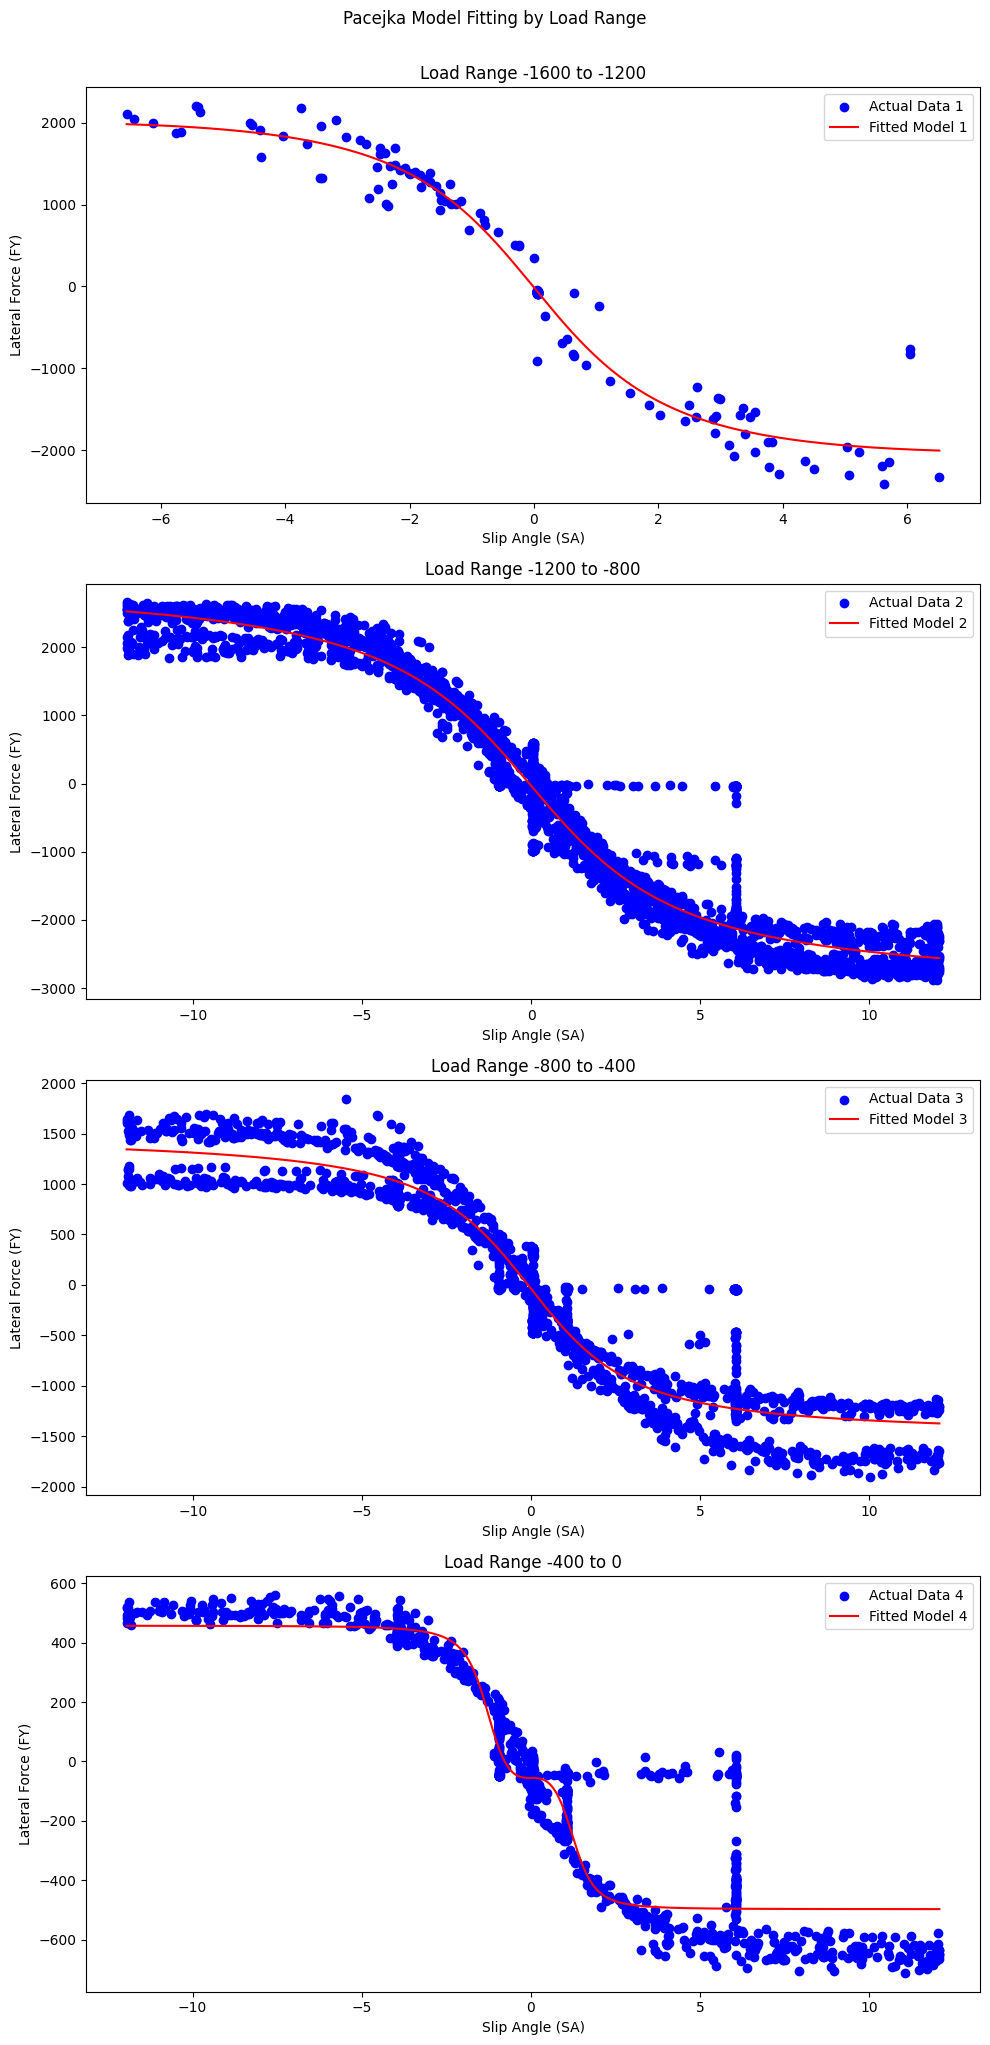

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Define the path to the CSV file
#data_path = '/Users/nicholaslemoff/Desktop/FEBSim/TireSim/tirecsvfiles/B1320run52.csv'


# file path:

data_path = "0DegConcatTireData_shifted_scaled_1000.dat"


# Load the data, skipping the first row which contains units
data = pd.read_csv(data_path,delimiter='\t')

# Convert relevant columns to numeric types, assuming 'deg' is slip angle, 'N.1' is lateral force, and 'N.2' is vertical load
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FY'] = pd.to_numeric(data['FY'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')

# Flip the sign of FY to match the coordinate system
data['FY'] = data['FY'] * -1

# Define vertical load ranges for splitting the data
load_ranges = [(-1600, -1200), (-1200, -800), (-800, -400), (-400, 0)]

# Create a subplot figure with the number of load ranges
fig, axs = plt.subplots(len(load_ranges), 1, figsize=(10, len(load_ranges) * 5))

# Process each load range
for i, (lower_bound, upper_bound) in enumerate(load_ranges, start=1):
    # Filter the data based on the current load range
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    # Prepare the data for curve fitting
    x_data = load_data['SA']
    y_data = load_data['FY']

    # Apply curve fitting to find the optimal coefficients for each load range
    initial_guess = [0.5, 1.2, max(load_data['FY']), 1, 0]
    optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)

    # Generate model predictions over the range of slip angles for visualization
    x_model = np.linspace(x_data.min(), x_data.max(), 500)
    y_model = pacejka_model(x_model, *optimal_parameters)

    # Calculate R^2 accuracy for each fitted curve
    y_pred = pacejka_model(x_data, *optimal_parameters)
    ss_res = np.sum((y_data - y_pred) ** 2)
    ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Use the appropriate subplot
    ax = axs[i - 1] if len(load_ranges) > 1 else axs

    # Add the scatter plot for actual data and the line plot for the fitted curve to the subplot
    ax.scatter(x_data, y_data, color='blue', label=f'Actual Data {i}')
    ax.plot(x_model, y_model, color= 'red', label=f'Fitted Model {i}')

    # Enhance the subplot
    ax.set_title(f'Load Range {lower_bound} to {upper_bound}')
    ax.set_xlabel('Slip Angle (SA)')
    ax.set_ylabel('Lateral Force (FY)')
    ax.legend()

    # Print the optimal parameters and R^2 value for the current load range
    print(f"Load Range {lower_bound} to {upper_bound}")
    print(f"Optimal Parameters:\nB: {optimal_parameters[0]}\nC: {optimal_parameters[1]}\nD: {optimal_parameters[2]}\nE: {optimal_parameters[3]}\nF: {optimal_parameters[4]}")
    print(f"R² Accuracy: {r_squared:.3f}\n")

# Enhancing the overall plot
plt.tight_layout()
plt.suptitle("Pacejka Model Fitting by Load Range", y=1.02)

# Display the plot
plt.show()

In [11]:
df

,SA,FY,FZ
0,0.0641,87.39,-660.96
1,0.0671,87.38,-661.43
2,0.0601,85.99,-664.41
3,0.0551,87.40,-662.04
4,0.0651,74.71,-270.66
...,...,...,...
14377,0.0621,90.54,-1571.52
14378,0.0481,87.16,-1577.22
14379,0.0521,85.51,-1541.27
14380,0.0471,74.58,-1555.39
